필요한 클래스, 라이브러리

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
import torch
import warnings
from transformers import BertModel, BertTokenizer
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
os.environ['OMP_NUM_THREADS'] = '1'


okt=Okt()
vectorizer=TfidfVectorizer()

웹 크롤링해서 Df 만들기

In [3]:
url="https://www.safetydata.go.kr/disaster-data/disasterNotification?searchStartDttm=&searchEndDttm=&keyword=&orderBy=&currentPage=1&cntPerPage=12000&pageSize=12000"

response=requests.get(url)

if response.status_code == 200:
    file_path = "disaster_message.html"

    with open(file_path, "w", encoding="utf-8") as file:
        file.write(response.text)

    print(f"HTML content has been downloaded and saved to {file_path}.")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")

filename="disaster_message.html"
html=""
with open (filename, 'r', encoding='UTF-8') as file:
    for line in file:
        html+=line

soup=BeautifulSoup(html,'lxml')

rows=soup.find_all('tr')
data_list=[]

for row in rows:
    cols=row.find_all('td')
    cols=[ele.text.strip() for ele in cols]
    data_list.append(cols)

df=pd.DataFrame(data_list, columns=['number','text','time'])

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print(df.head())

HTML content has been downloaded and saved to disaster_message.html.
  number  \
0   None   
1  11995   
2  11994   
3  11993   
4  11992   

                                                                                          text  \
0                                                                                         None   
1  도내 폭염특보 발효중(최고 체감온도 35℃ 이상), 무더위쉼터 이용, 폭염안전수칙(물, 그늘, 휴식)준수, 한낮 야외작업 자제 등 안전에 유의 바랍니다[경상남도]N   
2  상주시 폭염경보 발효중(최고 체감온도 34℃ 이상), 무더위쉼터 이용, 폭염안전수칙(물, 그늘, 휴식)준수, 한낮 야외작업 자제 등 안전에 유의 바랍니다[상주시]N   
3                        폭염경보 발효중. 야외 활동을 자제하세요, 충분히 물을 마시고 그늘에서 휴식을 취하는 등 건강관리에 유의하세요. [함평군]N   
4  폭염경보 발효 중입니다. 물을 자주 마시고 개인 건강에 유의하시기 바라며, 야외활동을 자제하고 현장 근로자들은 무더운 낮시간에 휴식하여 주시기 바랍니다.[창원시]N   

                  time  
0                 None  
1  2024/07/29 12:00:29  
2  2024/07/29 11:59:19  
3  2024/07/29 11:45:41  
4  2024/07/29 11:29:36  


데이터 개수로 index 바꾸고(과거~현재 순서), 위치(발송처) 정보 분리

In [4]:
df=df.drop(0)
df=df.reset_index(drop=True)

df=df.dropna()
df = df.drop_duplicates()
df['number']=pd.to_numeric(df['number'])
df = df.sort_values(by='number', ascending=True)
df = df.set_index('number')

def extract_location(text):
    if text is None:
        return text, 'NaN'
    start=text.rfind('[')
    end=text.rfind(']')
    if start!=-1 and end!=-1:
        location=text[start+1:end]
        text=text[:start]+text[end+1:]
    else:
        location='NaN'
    return text.strip(), location

df[['text', 'location']] = df['text'].apply(lambda x: pd.Series(extract_location(x)))

pd.set_option('display.max_colwidth', None)

print("Df has completed.")

Df has completed.


text 전처리1: 필요 없어 보이는 문자 제거(주관적 기준)

In [5]:
def preprocessing(text):
    text=text.replace("△", "")
    text=text.replace("\n","")
    text=text.replace("N","")
    text=text.replace("▲","")
    tokens=okt.morphs(text, stem=True)
    return ' '.join(tokens)

df['text']=df['text'].apply(lambda x: preprocessing(x))

print("preprocessing complete.")

preprocessing complete.


정규표현식으로 특수문자 모두 제거

In [ ]:
import re
import torch
from transformers import BertTokenizer, BertModel
import warnings

# Ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning, module='huggingface_hub')

# Function to clean and preprocess text
def clean_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.lower().strip()

# Assuming df is your DataFrame
df['clean_text'] = df['text'].apply(clean_text)

kobert 모델 이용해 K-means 알고리즘으로 위험도(risk_value) 분류

In [9]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [17]:
tokenizer = BertTokenizer.from_pretrained("monologg/kobert")

def encode_texts(texts, tokenizer, max_length=64):
    return tokenizer(texts.tolist(), max_length=max_length, truncation=True, padding=True, return_tensors='pt')

encoded_texts = encode_texts(df['text'], tokenizer, max_length=64)



# Load pre-trained KoBERT model
model = BertModel.from_pretrained("monologg/kobert")
warnings.filterwarnings("ignore", category=FutureWarning, module='huggingface_hub')

'''
def get_embeddings(model, encoded_texts, batch_size=8):
    model.eval()  # Set the model to evaluation mode
    embeddings = []
    with torch.no_grad():  # Disable gradient calculation
        for i in range(0, len(encoded_texts['input_ids']), batch_size):
            batch_input_ids = encoded_texts['input_ids'][i:i+batch_size]
            batch_attention_mask = encoded_texts['attention_mask'][i:i+batch_size]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            embeddings.append(outputs.last_hidden_state[:, 0, :])  # Use [CLS] token embeddings
    return torch.cat(embeddings, dim=0)
'''

def get_embeddings(model, encoded_texts, batch_size=8):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(encoded_texts['input_ids']), batch_size):
            batch_input_ids = encoded_texts['input_ids'][i:i+batch_size]
            batch_attention_mask = encoded_texts['attention_mask'][i:i+batch_size]
            outputs = model(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
            # Pooler output or mean across the last hidden states can be used
            pooled_output = outputs.pooler_output  # Or try mean pooling: torch.mean(outputs.last_hidden_state, dim=1)
            embeddings.append(pooled_output)
    return torch.cat(embeddings, dim=0)


embeddings = get_embeddings(model, encoded_texts, batch_size=8)

NUM_CLUSTERS = 8
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
df['risk_cluster'] = kmeans.fit_predict(embeddings.numpy())

print(df.head(20))

                                                                                                                      text  \
number                                                                                                                       
1                            오늘 00시 30분 부산 지역 호우경보 발효 . 많다 비 와 낙뢰 가 예상 되다 저 지대 , 침수 위험 지역 접근 금지 및 외출 자제 등 안전 에 유의 하다 바라다 .   
2             완주군 에서 배회 중 인 민 도식 씨 ( 남 , 70 세 ) 를 찾다 - 160 cm , 회색 줄무늬 티 , 검정 칠 부등 산바 지 , 검정 운동화 , 지팡이 vo.la/TXWtJ / ☎ 182   
3       전주시 에서 실종 되다 민 도식 씨 ( 남 , 70 세 ) 를 찾다 - 160 cm , 55 kg , 회색 줄무늬 티 , 검정 칠 부등 산바 지 , 검정 운동화 , 지팡 이vo.la/TXWtJ/ ☎ 182   
4                현재 지방도 1040 호선 의령읍 정암 리 ~ 만 천리 구간 ( 정암 철교 ~ 수협 사료 삼거리 ) 비탈 면 토 석 유출 로 전면 통제 중 이니 , 교통 정보 확인 후 우회 하다 바라다 .   
5                                   많다 비 가 내리다 있다 . 가급적 대중교통 을 이용 하다 , 운전 시 지하차도 등 저 지대 는 침수 우려 가 있다 속도 를 줄 이고 안전 운전 바라다 .   
6                        지속 되다 호우 로 수위 가 높아지다 대천천 산책로 , 화 명 생태 공원 산책로 및 차량 진출 입로 를 지속 통제 중 이오니 , 출퇴근 차량 은 우회 하다 주 시기 바

학습결과 시각화

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

embeddings_np = embeddings.numpy()

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_np)

visualization_df = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
visualization_df['cluster'] = df['risk_cluster']

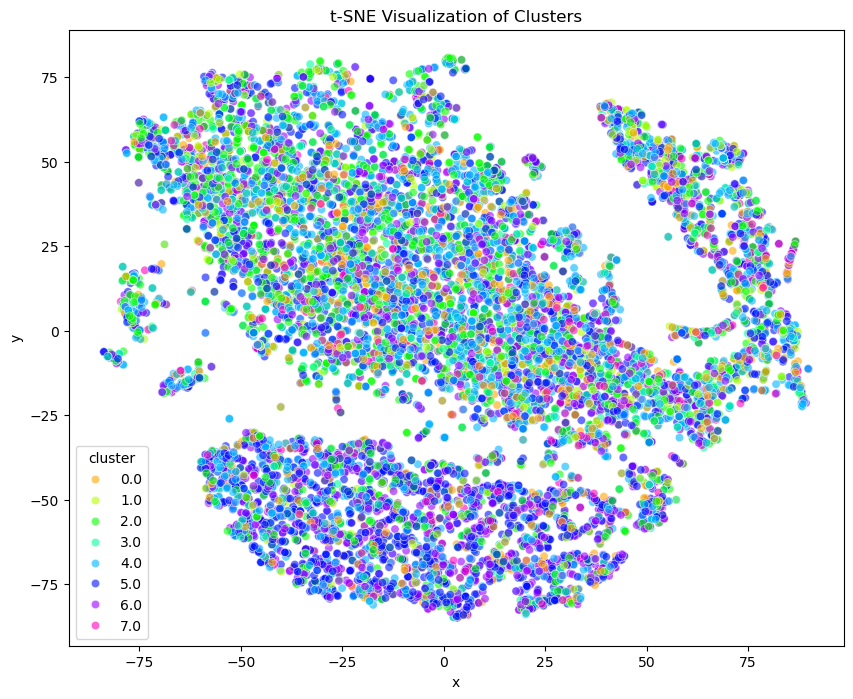

In [19]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='x', y='y',
    hue='cluster',
    palette=sns.color_palette("hsv", NUM_CLUSTERS),
    data=visualization_df,
    legend="full",
    alpha=0.6
)
plt.title("t-SNE Visualization of Clusters")
plt.show()

엑셀로 파일 변환

In [20]:
output_file = "risk_value1.xlsx"

df.to_excel(output_file, index=False, engine='openpyxl')

print(f"DataFrame has been exported to {output_file}")

DataFrame has been exported to risk_value1.xlsx
